# Gradient Boosted Classifier attempt to Titanic Kaggle competition.
As a first model we try the Gradient Boosted Classifier.

The study roadmap:

1. Get data and visualise it
* Train basic version of xgboost classifier
* Tune model hyperparameters
* Perform features engineering  

In [1]:
print("Kernel is alive")

Kernel is alive


In [179]:
# all imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

#sklearn imports 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import roc_curve, auc
from sklearn import grid_search
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix

import csv as csv

import itertools

# Get training and test data

In [6]:
train_df = pd.read_csv('../datasets/train.csv', header=0)        # Load the train file into a dataframe
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
test_df = pd.read_csv('../datasets/test.csv', header=0)        # Load the train file into a dataframe
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## So now we clearly see that data is very dirty. We need to clean it a little bit. 
The next step is based on script myfirstforest.py

In [29]:
def clean_data(dataframe):
    ports_names = list(enumerate(np.unique(train_df['Embarked'])))    # determine all values of Embarked,
    median_age = train_df['Age'].dropna().median()
    dataframe['Gender'] = dataframe['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    if len(dataframe.Embarked[ dataframe.Embarked.isnull() ]) > 0:
        dataframe.Embarked[ train_df.Embarked.isnull() ] = dataframe.Embarked.dropna().mode().values

    Ports_dict = { name : i for i, name in ports_names }              # set up a dictionary in the form  Ports : index
    dataframe.Embarked = train_df.Embarked.map( lambda x: Ports_dict[x]).astype(int)     # Convert all Embark strings to int
    # All the ages with no data -> make the median of all Ages
    if len(dataframe.Age[ dataframe.Age.isnull() ]) > 0:
        dataframe.loc[ (dataframe.Age.isnull()), 'Age'] = median_age
    # All the missing Fares -> assume median of their respective class
    if len(test_df.Fare[ test_df.Fare.isnull() ]) > 0:
        median_fare = np.zeros(3)
        for f in range(0,3):                                              # loop 0 to 2
            median_fare[f] = test_df[ test_df.Pclass == f+1 ]['Fare'].dropna().median()
        for f in range(0,3):                                              # loop 0 to 2
            test_df.loc[ (test_df.Fare.isnull()) & (test_df.Pclass == f+1 ), 'Fare'] = median_fare[f]


In [35]:
clean_data(train_df)
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,2,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,2,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,2,1


In [36]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Gender
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208,1.536476,0.647587
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429,0.791503,0.477990
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,1.000000,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,2.000000,1.000000
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,2.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,2.000000,1.000000


In [33]:
clean_data(test_df)
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,2,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,0,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,2,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,2,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,2,0


## Remove useless columns. 
In the further studies we can use Cabin or ticket infor but it is quite tricky. 

In [57]:
target = train_df.Survived
features = train_df.drop(["Survived",'Name', 'Sex', 'Ticket', 'Cabin', 'PassengerId'], axis=1).astype(numpy.float64)
features.head()

,Pclass,Age,SibSp,Parch,Fare,Embarked,Gender
0,3.0,22.0,1.0,0.0,7.2500,2.0,1.0
1,1.0,38.0,1.0,0.0,71.2833,0.0,0.0
2,3.0,26.0,0.0,0.0,7.9250,2.0,0.0
3,1.0,35.0,1.0,0.0,53.1000,2.0,0.0
4,3.0,35.0,0.0,0.0,8.0500,2.0,1.0


### Prepare test dataframe 

In [176]:
ids = test_df['PassengerId'].values
test_features = test_df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'PassengerId'], axis=1) 

# Data visualization
Now I made a couple of plots that show us the data structures

In [74]:
def print_features_histograms(features, target):
    hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
    # create the figure
    fig = plt.figure(figsize=(10,  20))
    for n, feature in enumerate(features):
        # add sub plot on our figure
        ax = fig.add_subplot(features.shape[1] // 2 + 1, 2, n + 1)
        # define range for histograms by cutting 1% of data from both ends
        min_value, max_value = numpy.percentile(features[feature], [1, 99])
        ax.hist(features.ix[target == 0, feature].values, range=(min_value, max_value), 
                 label='death', **hist_params)
        ax.hist(features.ix[target == 1, feature].values, range=(min_value, max_value), 
                 label='alive', **hist_params)
        ax.legend(loc='best')

        ax.set_title(feature)

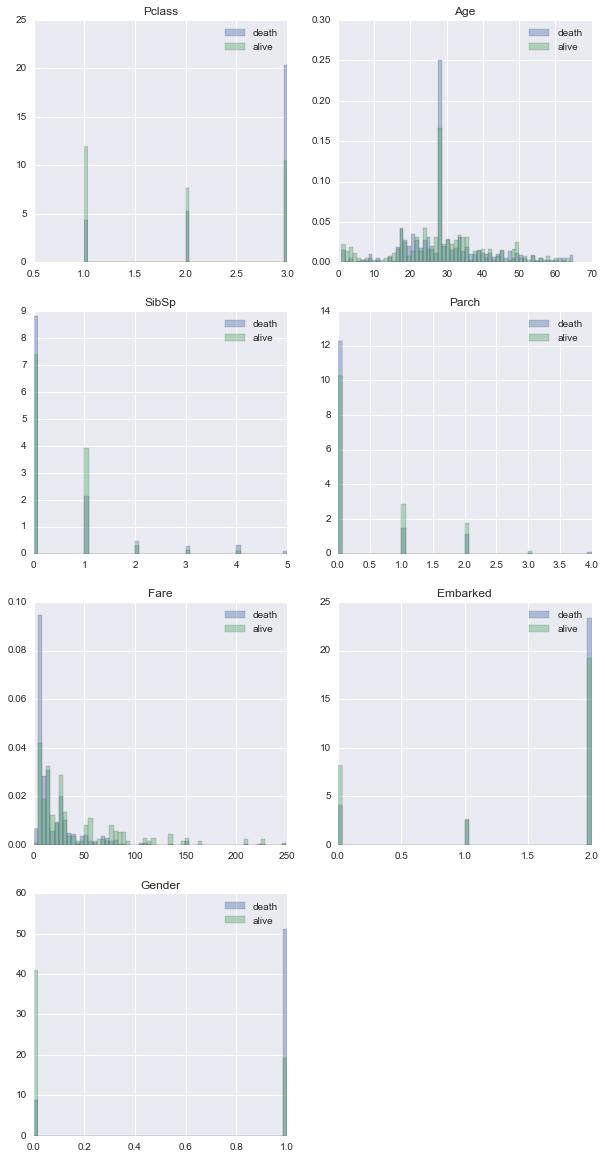

In [75]:
print_features_histograms(features, target)

In [70]:
def pairplot(data, vars):
    sns.pairplot(data, hue="Survived", vars=vars, plot_kws={'alpha': 0.5, 'marker': '*'})


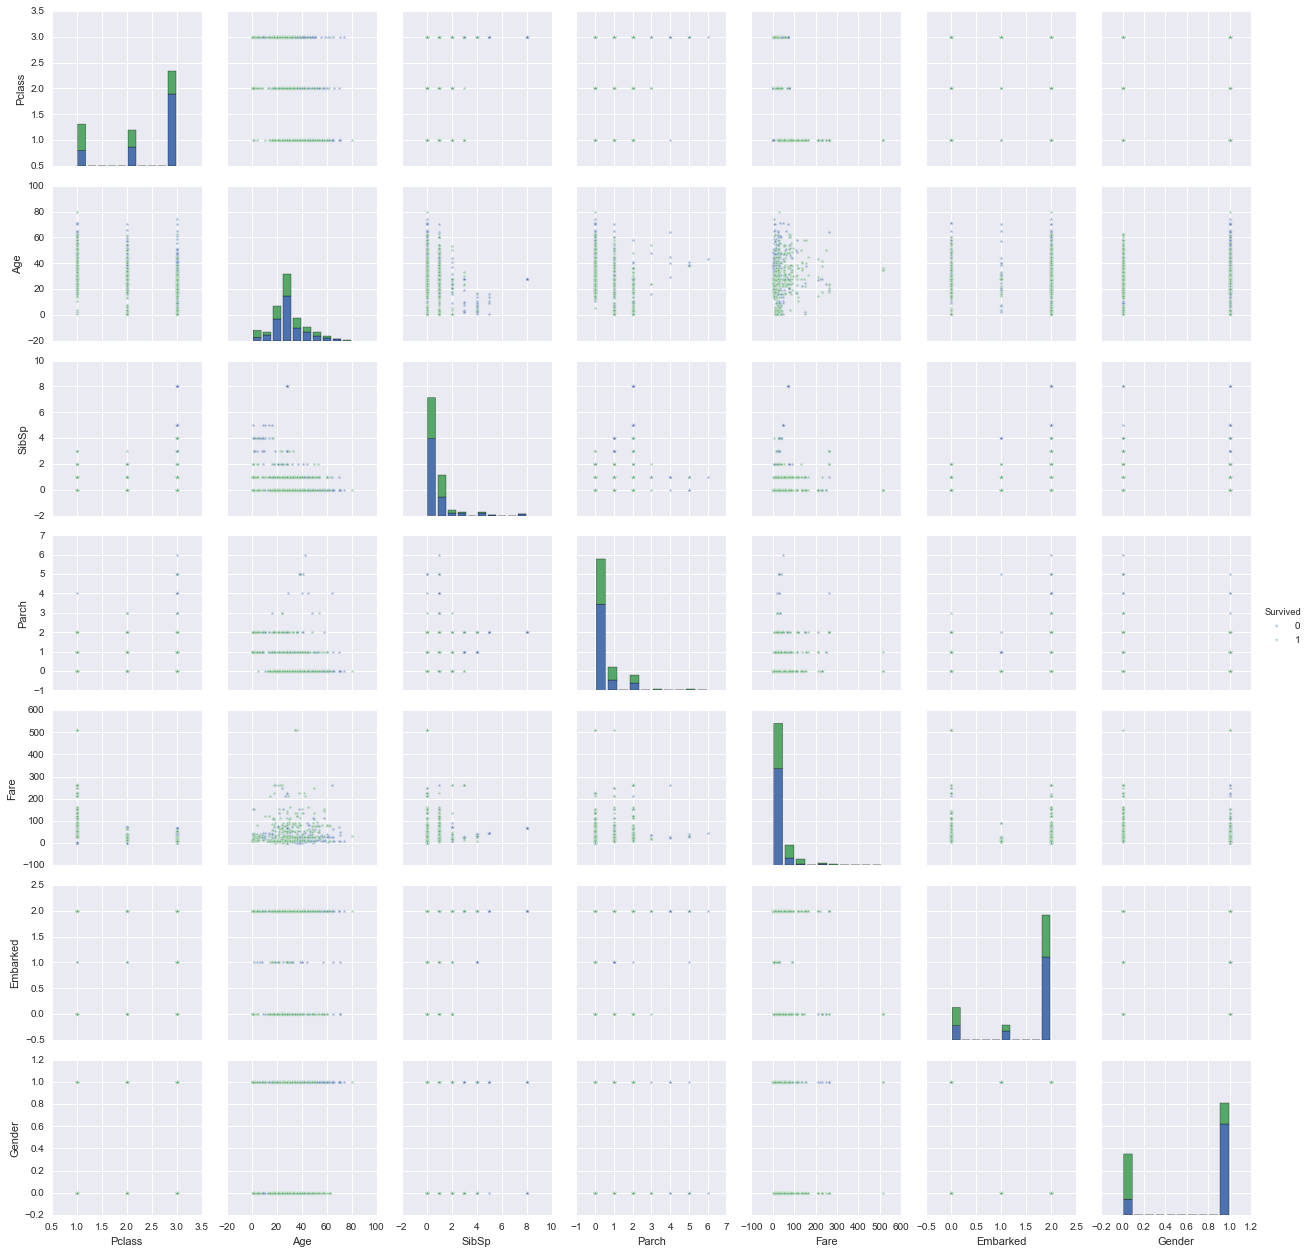

In [71]:
pairplot(train_df,vars=features.columns.values)

## show the correlation matrix

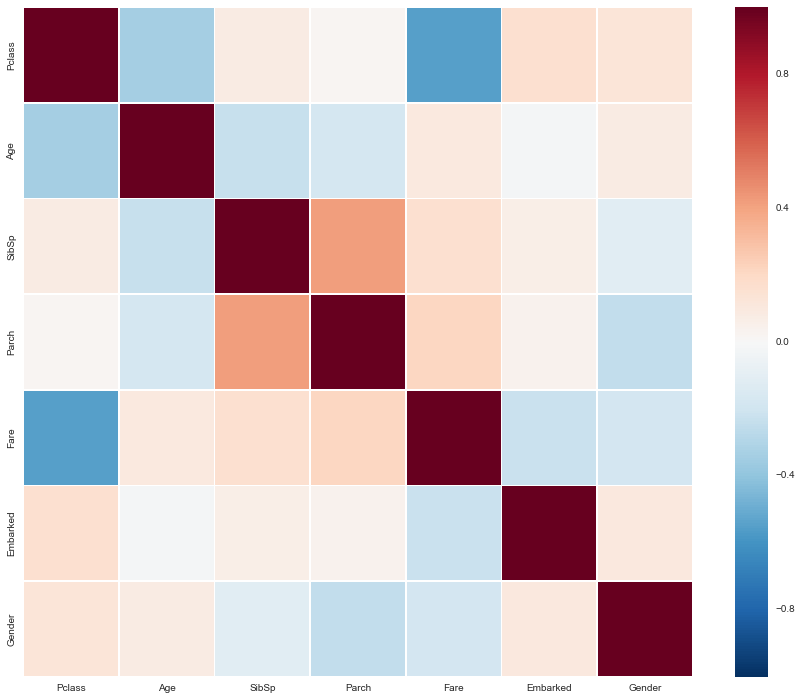

In [73]:
cor_mat = features.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(cor_mat,linewidths=.5, ax=ax);

## Survived correlation map

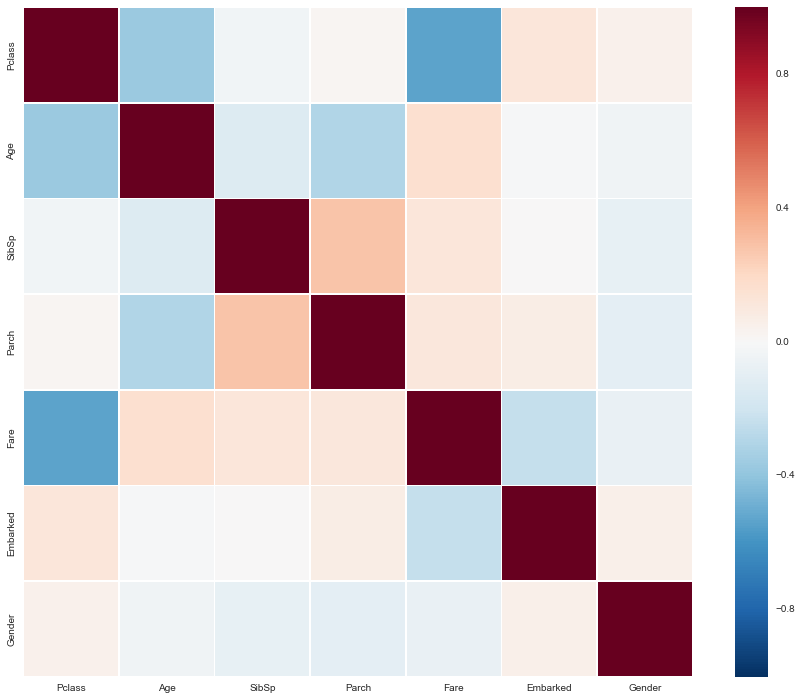

In [77]:
cor_mat = features[target==1].corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(cor_mat,linewidths=.5, ax=ax);

## Death correlation map

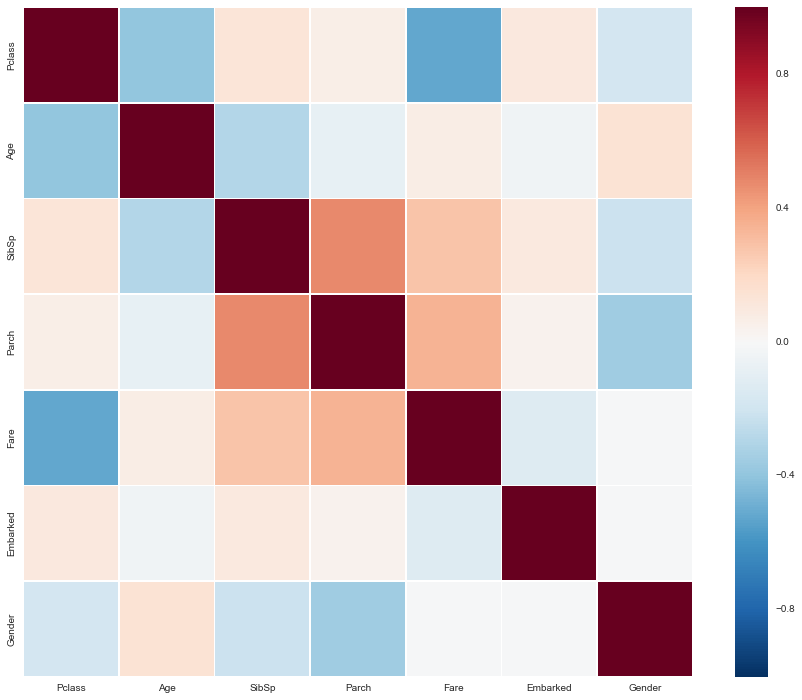

In [79]:
cor_mat = features[target==0].corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(cor_mat,linewidths=.5, ax=ax);

## test visualization

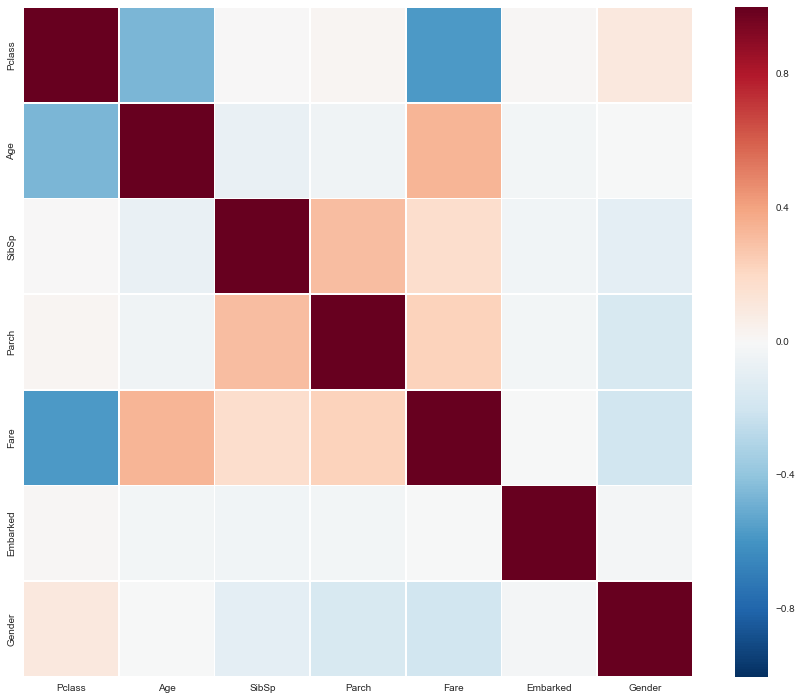

In [185]:
cor_mat = test_features.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(cor_mat,linewidths=.5, ax=ax);

In [186]:
def pairplot_test(data, vars):
    sns.pairplot(data, vars=vars, plot_kws={'alpha': 0.5, 'marker': '*'})


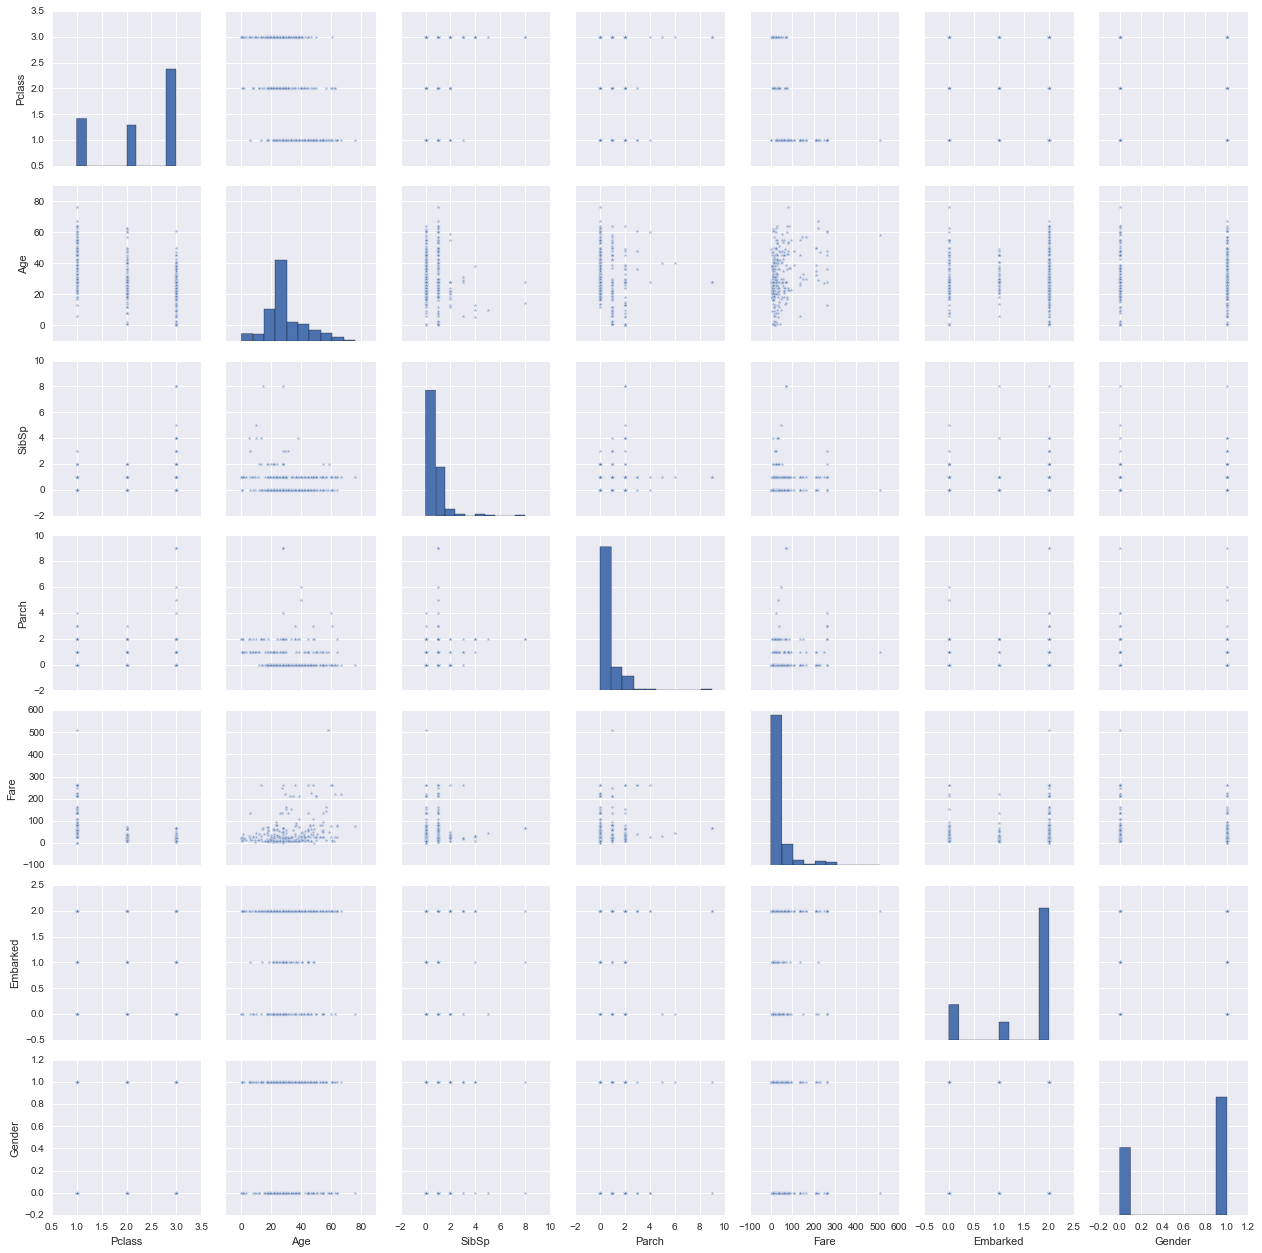

In [188]:
pairplot_test(test_df,vars=test_features.columns.values)

In [189]:
def print_features_histograms_test(features):
    hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
    # create the figure
    fig = plt.figure(figsize=(10,  20))
    for n, feature in enumerate(features):
        # add sub plot on our figure
        ax = fig.add_subplot(features.shape[1] // 2 + 1, 2, n + 1)
        # define range for histograms by cutting 1% of data from both ends
        min_value, max_value = numpy.percentile(features[feature], [1, 99])
        ax.hist(features.ix[target == 0, feature].values, range=(min_value, max_value), 
                 label='test', **hist_params)
        ax.legend(loc='best')

        ax.set_title(feature)

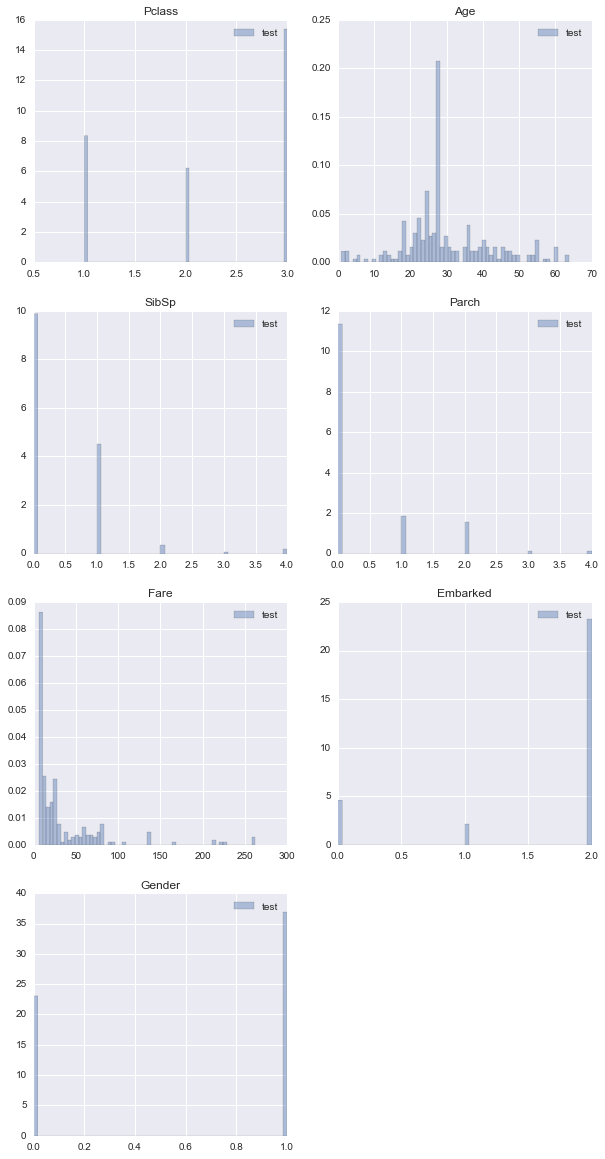

In [190]:
print_features_histograms_test(test_features)

## Check whether the dataset is balanced

It is tricky to train model using misbalanced data. 

In [87]:
alive_nb = features[target == 1].count()[0]
death_nb = features[target == 0].count()[0]
print("alive_nb %d") % alive_nb
print("death_nb %d") % death_nb
ratio_death_to_alive = float(death_nb)/alive_nb
ratio_death_to_alive = numpy.round(ratio_death_to_alive, 3)
print ("ratio ghost to good %f") % ratio_death_to_alive

alive_nb 342
death_nb 549
ratio ghost to good 1.605000


# Train the basic version of Gradient Boosted Classifier

In [191]:
trainX, testX, trainY, testY = train_test_split(features, target, random_state=42,train_size=0.5 )
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, subsample=0.8, random_state=13,
                                min_samples_leaf=100, max_depth=6, verbose = 3 )
gb.fit(trainX,trainY)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2520           0.0620           27.17s
         2           1.2034           0.0362           13.81s
         3           1.1724           0.0427            9.35s
         4           1.1453           0.0236            7.13s
         5           1.1103           0.0205            5.79s
         6           1.0999           0.0158            5.26s
         7           1.0685           0.0096            4.64s
         8           1.0721           0.0150            4.13s
         9           1.0445           0.0138            3.72s
        10           1.0462           0.0026            3.38s
        11           1.0267           0.0078            3.11s
        12           1.0414           0.0064            2.87s
        13           1.0247           0.0095            2.68s
        14           1.0316           0.0019            2.52s
        15           0.9812           0.0009            2.38s
       

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=13, subsample=0.8, verbose=3,
              warm_start=False)

In [192]:
print "ROC AUC score of simple BDT"
roc_auc_score(testY, gb.predict_proba(testX)[:, 1])


ROC AUC score of simple BDT


0.83178498943359891

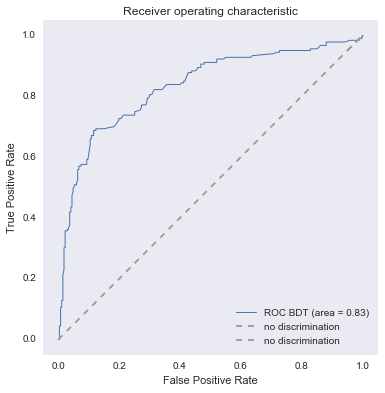

In [193]:
plt.figure(figsize=[6, 6])
fpr, tpr, thresholds = roc_curve(testY, gb.predict_proba(testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.plot([0.95, 1], [0.95, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [194]:
target_names = ['background', "signal"]
print("classification raport test")
print(classification_report(testY, gb.predict(testX), target_names=target_names))


classification raport test
             precision    recall  f1-score   support

 background       0.81      0.88      0.84       267
     signal       0.79      0.69      0.74       179

avg / total       0.80      0.80      0.80       446



In [195]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[234  33]
 [ 55 124]]


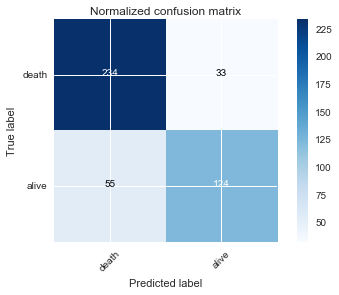

In [196]:
cnf_matrix = confusion_matrix(testY ,gb.predict(testX));
target_names = ["death","alive"]
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Normalized confusion matrix')


## The most important metrics accurency
This is a pretty bad results about 182 possition :( 

In [197]:
accuracy_score(testY ,gb.predict(testX))

0.80269058295964124

In [198]:
accuracy_score(trainY ,gb.predict(trainX))

0.8539325842696629

## Plot learning rate

In [199]:
predictions = gb.staged_predict(testX)
tree_scores = [] 
for predicted in predictions:
    score =  accuracy_score(testY, predicted)
    tree_scores.append(score)

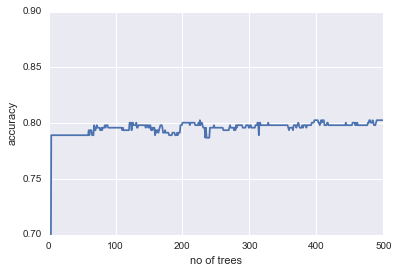

In [200]:
x = numpy.array([x  for x in range(500)])
plt.figure()
plt.plot(x,tree_scores)
plt.ylim(0.7, 0.9)
plt.xlabel('no of trees')
plt.ylabel('accuracy')
plt.show()

# Try to tune model hyperparameters to beat this reault

In [212]:

gb_grid_params = {'learning_rate': [0.3, 0.2, 0.1],
              'max_depth': [3, 4, 6, 8 ],
              'min_samples_leaf': [20, 50,100,150]
              }
print(gb_grid_params)

gb_gs = GradientBoostingClassifier(n_estimators = 600, subsample=0.8, random_state=13)


clf = grid_search.GridSearchCV(gb_gs,
                               gb_grid_params,
                               cv=3,
                               scoring='accuracy',
                               verbose = 3, 
                               n_jobs=10);
clf.fit(testX, testY)

{'learning_rate': [0.3, 0.2, 0.1], 'max_depth': [3, 4, 6, 8], 'min_samples_leaf': [20, 50, 100, 150]}
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] learning_rate=0.3, max_depth=3, min_samples_leaf=20 .............
[CV] learning_rate=0.3, max_depth=3, min_samples_leaf=20 .............
[CV] learning_rate=0.3, max_depth=3, min_samples_leaf=20 .............
[CV] learning_rate=0.3, max_depth=3, min_samples_leaf=50 .............
[CV] learning_rate=0.3, max_depth=3, min_samples_leaf=50 .............
[CV] learning_rate=0.3, max_depth=3, min_samples_leaf=50 .............
[CV] learning_rate=0.3, max_depth=3, min_samples_leaf=100 ............
[CV] learning_rate=0.3, max_depth=3, min_samples_leaf=100 ............
[CV] learning_rate=0.3, max_depth=3, min_samples_leaf=150 ............
[CV] learning_rate=0.3, max_depth=3, min_samples_leaf=100 ............
[CV]  learning_rate=0.3, max_depth=3, min_samples_leaf=150, score=0.597315 -   1.3s
[CV] learning_rate=0.3, max_depth=3, min_s

[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.1s


[CV]  learning_rate=0.3, max_depth=4, min_samples_leaf=50, score=0.798658 -   1.7s
[CV] learning_rate=0.3, max_depth=4, min_samples_leaf=150 ............
[CV]  learning_rate=0.3, max_depth=4, min_samples_leaf=100, score=0.765101 -   1.5s
[CV]  learning_rate=0.3, max_depth=4, min_samples_leaf=100, score=0.711409 -   1.5s
[CV] learning_rate=0.3, max_depth=4, min_samples_leaf=150 ............
[CV]  learning_rate=0.3, max_depth=4, min_samples_leaf=50, score=0.778523 -   1.8s
[CV] learning_rate=0.3, max_depth=6, min_samples_leaf=20 .............
[CV] learning_rate=0.3, max_depth=6, min_samples_leaf=20 .............
[CV]  learning_rate=0.3, max_depth=4, min_samples_leaf=20, score=0.751678 -   2.3s
[CV]  learning_rate=0.3, max_depth=4, min_samples_leaf=50, score=0.695946 -   1.7s
[CV] learning_rate=0.3, max_depth=6, min_samples_leaf=20 .............
[CV] learning_rate=0.3, max_depth=6, min_samples_leaf=50 .............
[CV]  learning_rate=0.3, max_depth=4, min_samples_leaf=20, score=0.771812 

[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   19.7s


[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=100, score=0.718121 -   1.1s
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=150 ............
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=50, score=0.785235 -   1.4s
[CV] learning_rate=0.1, max_depth=4, min_samples_leaf=150 ............
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=50, score=0.812081 -   1.4s
[CV] learning_rate=0.1, max_depth=6, min_samples_leaf=20 .............
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=100, score=0.805369 -   1.1s
[CV] learning_rate=0.1, max_depth=6, min_samples_leaf=20 .............
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=50, score=0.689189 -   1.4s
[CV] learning_rate=0.1, max_depth=6, min_samples_leaf=20 .............
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=20, score=0.798658 -   1.9s
[CV] learning_rate=0.1, max_depth=6, min_samples_leaf=50 .............
[CV]  learning_rate=0.1, max_depth=4, min_samples_leaf=20, score=0.778523 

[Parallel(n_jobs=10)]: Done 144 out of 144 | elapsed:   24.8s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              presort='auto', random_state=13, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=10,
       param_grid={'learning_rate': [0.3, 0.2, 0.1], 'max_depth': [3, 4, 6, 8], 'min_samples_leaf': [20, 50, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=3)

In [213]:
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() * 2, params))

Best parameters set found on development set:
{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 20}
Grid scores on development set:
0.747 (+/-0.043) for {'learning_rate': 0.3, 'max_depth': 3, 'min_samples_leaf': 20}
0.758 (+/-0.089) for {'learning_rate': 0.3, 'max_depth': 3, 'min_samples_leaf': 50}
0.724 (+/-0.059) for {'learning_rate': 0.3, 'max_depth': 3, 'min_samples_leaf': 100}
0.599 (+/-0.004) for {'learning_rate': 0.3, 'max_depth': 3, 'min_samples_leaf': 150}
0.758 (+/-0.020) for {'learning_rate': 0.3, 'max_depth': 4, 'min_samples_leaf': 20}
0.758 (+/-0.089) for {'learning_rate': 0.3, 'max_depth': 4, 'min_samples_leaf': 50}
0.724 (+/-0.059) for {'learning_rate': 0.3, 'max_depth': 4, 'min_samples_leaf': 100}
0.599 (+/-0.004) for {'learning_rate': 0.3, 'max_depth': 4, 'min_samples_leaf': 150}
0.767 (+/-0.053) for {'learning_rate': 0.3, 'max_depth': 6, 'min_samples_leaf': 20}
0.758 (+/-0.089) for {'learning_rate': 0.3, 'max_depth': 6, 'min_samples_leaf': 50}
0.724 (+/-0.059

In [165]:
# Train the best model

In [219]:
trainX, testX, trainY, testY = train_test_split(features, target, random_state=42,train_size=0.5 )
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=600, subsample=0.8, random_state=13,
                                min_samples_leaf=20, max_depth=3, verbose = 3 )
gb.fit(features,target)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2519           0.0846            1.94s
         2           1.1817           0.0709            1.69s
         3           1.1082           0.0420            1.42s
         4           1.0619           0.0410            1.30s
         5           1.0176           0.0260            1.21s
         6           1.0108           0.0312            1.13s
         7           0.9596           0.0211            1.11s
         8           0.9611           0.0249            1.07s
         9           0.9335           0.0140            1.03s
        10           0.9154           0.0163            1.02s
        11           0.9123           0.0166            1.00s
        12           0.8788           0.0098            0.97s
        13           0.8758           0.0095            0.96s
        14           0.8648           0.0075            0.94s
        15           0.8391           0.0044            0.92s
       

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=20, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              presort='auto', random_state=13, subsample=0.8, verbose=3,
              warm_start=False)

In [220]:
accuracy_score(testY ,gb.predict(testX))

0.92600896860986548

Confusion matrix, without normalization
[[255  12]
 [ 21 158]]


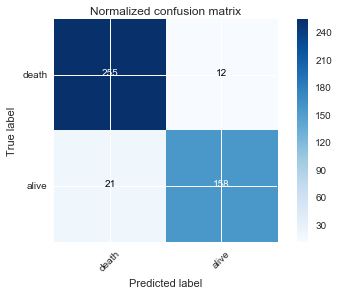

In [221]:
cnf_matrix = confusion_matrix(testY ,gb.predict(testX));
target_names = ["death","alive"]
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Normalized confusion matrix')


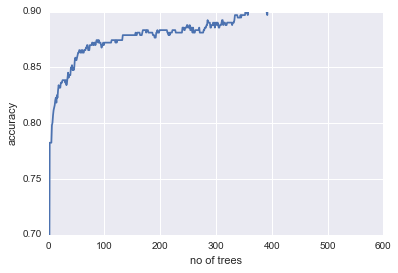

In [222]:
predictions = gb.staged_predict(testX)
tree_scores = [] 
for predicted in predictions:
    score =  accuracy_score(testY, predicted)
    tree_scores.append(score)
x = numpy.array([x  for x in range(600)])
plt.figure()
plt.plot(x,tree_scores)
plt.ylim(0.7, 0.9)
plt.xlabel('no of trees')
plt.ylabel('accuracy')
plt.show()

# Make submission

In [223]:
output = gb.predict(test_features).astype(int)
predictions_file = open("first_BDT.csv", "wb")
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()